In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
from utils import load_mnist
from trainer import Trainer

In [4]:
from argparse import Namespace

config = {
    'train_ratio': .8,
    'batch_size': 256,
    'n_epochs': 50,
    'verbose': 1,
    'btl_size': 2
}

config = Namespace(**config)

print(config)

Namespace(train_ratio=0.8, batch_size=256, n_epochs=50, verbose=1, btl_size=2)


In [20]:
def show_img(x):


    if x.dim() == 1:
        x = x.view(int(x.size(0) ** .5), -1)

    plt.imshow(x, cmap='gray')
    plt.show()

In [6]:
train_x, train_y = load_mnist(flatten=True)
test_x, test_y = load_mnist(is_train=False, flatten=True)

train_cnt = int(train_x.size(0) * config.train_ratio)
valid_cnt = train_x.size(0) - train_cnt

indices = torch.randperm(train_x.size(0))
train_x, valid_x = torch.index_select(train_x, dim=0, index=indices).split([train_cnt, valid_cnt], dim=0)
train_y, valid_y = torch.index_select(train_y, dim=0, index=indices).split([train_cnt, valid_cnt], dim=0)

print("Train:", train_x.shape, train_y.shape)
print("Valid:", valid_x.shape, valid_y.shape)
print("Test:", test_x.shape, test_y.shape)

Train: torch.Size([48000, 784]) torch.Size([48000])
Valid: torch.Size([12000, 784]) torch.Size([12000])
Test: torch.Size([10000, 784]) torch.Size([10000])


In [7]:
from model import Autoencoder

In [8]:
model = Autoencoder(btl_size=config.btl_size)
optimizer = optim.Adam(model.parameters())
crit = nn.MSELoss()

trainer = Trainer(model, optimizer, crit)

In [9]:
trainer.train((train_x, train_x), (valid_x, valid_x), config)

Epoch (1/50): train_loss=7.1223e-02  valid_loss=4.7768e-02  lowest_loss=4.7768e-02
Epoch (2/50): train_loss=4.6608e-02  valid_loss=4.3825e-02  lowest_loss=4.3825e-02
Epoch (3/50): train_loss=4.4075e-02  valid_loss=4.2051e-02  lowest_loss=4.2051e-02
Epoch (4/50): train_loss=4.2853e-02  valid_loss=4.1370e-02  lowest_loss=4.1370e-02
Epoch (5/50): train_loss=4.2046e-02  valid_loss=4.0964e-02  lowest_loss=4.0964e-02
Epoch (6/50): train_loss=4.1199e-02  valid_loss=3.9361e-02  lowest_loss=3.9361e-02
Epoch (7/50): train_loss=4.0624e-02  valid_loss=3.9452e-02  lowest_loss=3.9361e-02
Epoch (8/50): train_loss=4.0248e-02  valid_loss=3.9626e-02  lowest_loss=3.9361e-02
Epoch (9/50): train_loss=4.0033e-02  valid_loss=3.8495e-02  lowest_loss=3.8495e-02
Epoch (10/50): train_loss=3.9941e-02  valid_loss=3.9262e-02  lowest_loss=3.8495e-02
Epoch (11/50): train_loss=3.9586e-02  valid_loss=3.7966e-02  lowest_loss=3.7966e-02
Epoch (12/50): train_loss=3.9717e-02  valid_loss=3.7786e-02  lowest_loss=3.7786e-02
E

### Test

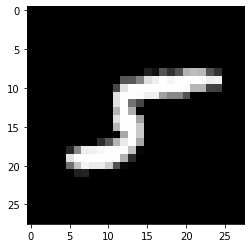

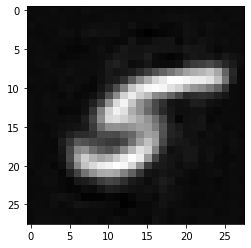

In [21]:
with torch.no_grad():
    import random

    index = int(random.random() * test_x.size(0))

    recon = model(test_x[index].view(1, -1)).squeeze() # test_x = (784, 1) -> (784,)

    show_img(test_x[index])
    show_img(recon)

### Latent(hidden) state = middle of the encoder and decoder

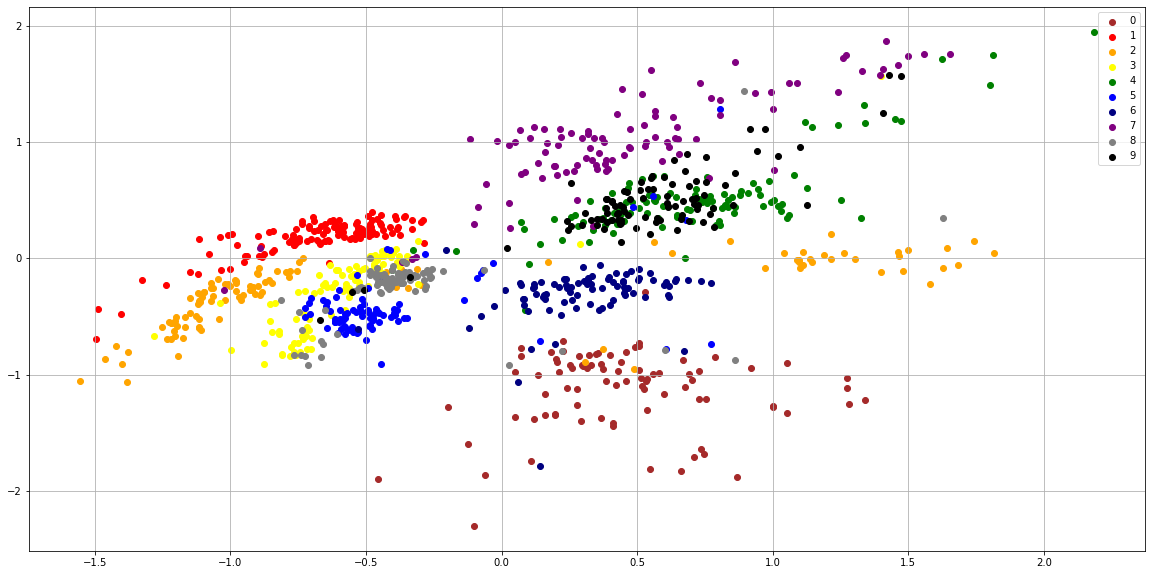

In [24]:
if config.btl_size == 2:
    color_map = [
        'brown', 'red', 'orange', 'yellow', 'green',
        'blue', 'navy', 'purple', 'gray', 'black',
    ]

    plt.figure(figsize=(20, 10))
    with torch.no_grad():
        latents = model.encoder(test_x[:1000])

        for i in range(10):
            target_latents = latents[test_y[:1000] == i]
            target_y = test_y[:1000][test_y[:1000] == i]
            plt.scatter(target_latents[:, 0],
                        target_latents[:, 1],
                        marker='o',
                        color=color_map[i],
                        label=i)

        plt.legend()
        plt.grid(axis='both')
        plt.show()

torch.Size([532, 28])


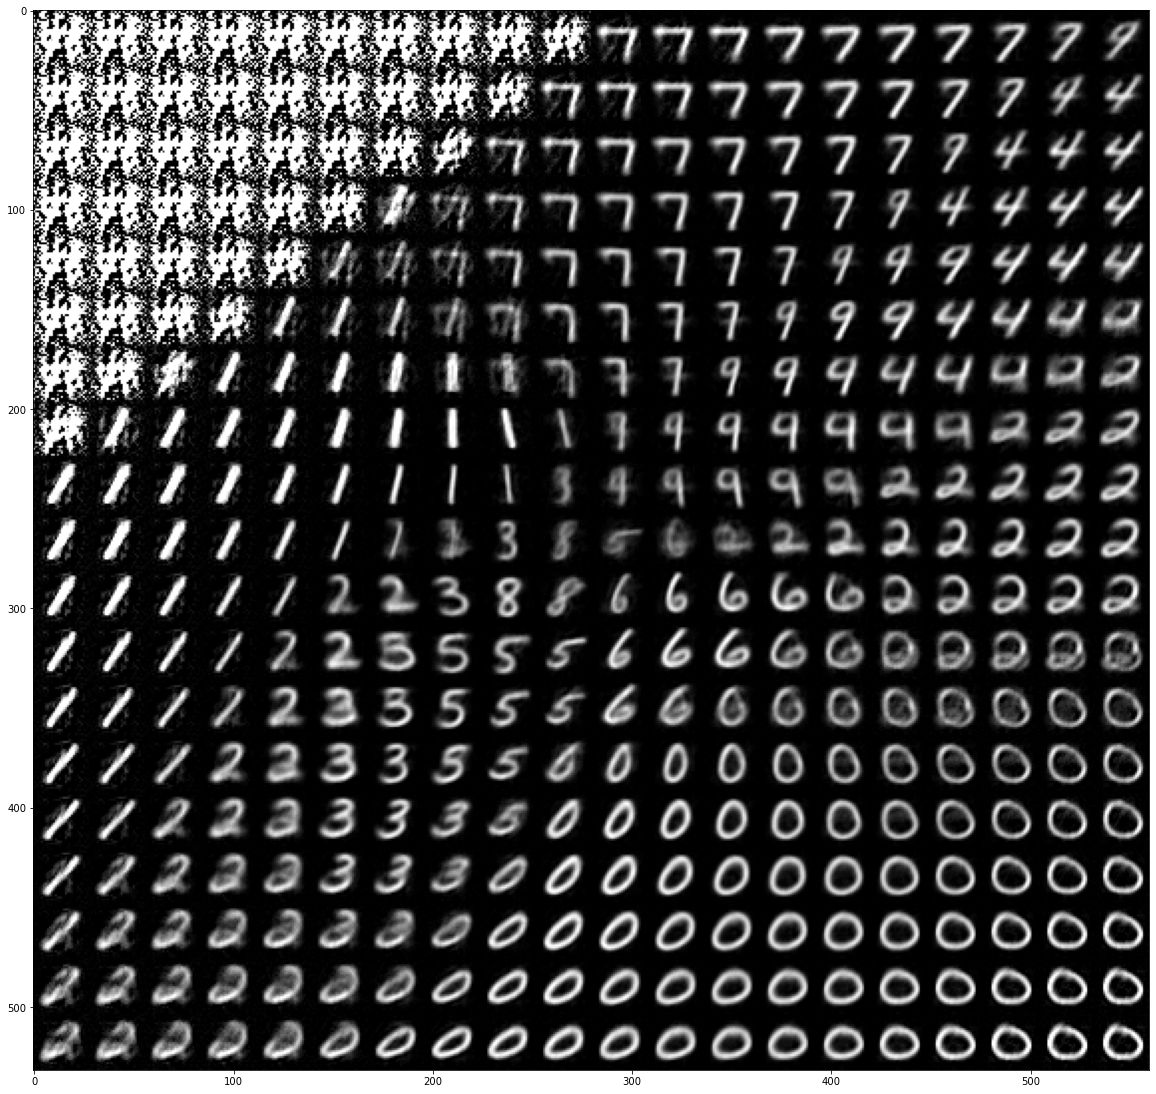

In [27]:
if config.btl_size == 2:
    min_range, max_range= -2., 2.
    n = 20
    step = (max_range - min_range) / float(n)

    with torch.no_grad():
        lines = []

        for v1 in np.arange(min_range, max_range, step):
            z = torch.stack([
                torch.FloatTensor([v1] * n),
                torch.FloatTensor([v2 for v2 in np.arange(min_range, max_range, step)]),
            ], dim=-1)

            line = torch.clamp(model.decoder(z).view(n, 28, 28), 0, 1)
            line = torch.cat([line[i] for i in range(n - 1, 0, -1)], dim=0)
            lines += [line]

        print(lines[0].shape)
        lines = torch.cat(lines, dim=-1)
        plt.figure(figsize=(20, 20))
        show_img(lines)